In [153]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [154]:
tickers = ["GNRC", "CPRT", "ODFL", "AMD", "PAYC", "CHTR", "MKC", "PG", "PGR", "NEM", "CCI"]

start_date = '2017-01-03'
end_date = '2021-09-01'

# panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [155]:
# close = panel_data['Close']
# adj_close = panel_data['Adj Close']

## Function that saves dataframe to CSV

In [156]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [157]:
for ticker in tickers:
    panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
    close = panel_data['Close']
    adj_close = panel_data['Adj Close']
#     save_dataframe_to_csv('close', close, ticker)
    save_dataframe_to_csv('adj_close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [158]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [159]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [160]:
for ticker in tickers:
    df = get_df_from_csv('adj_close', ticker)
    add_daily_return_to_df('adj_close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [161]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('adj_close', x)
        
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

In [162]:
port_list = ["AMD", "CPRT"]
mult_df = merge_df_by_column_name('daily_return', '2018-01-02', 
                                  '2021-09-10', *port_list)
mult_df

,AMD,CPRT
Date,,
2018-01-02,0.068093,0.009493
2018-01-03,0.051913,-0.004816
2018-01-04,0.049351,0.008066
2018-01-05,-0.019802,-0.004801
2018-01-08,0.033670,0.000459
...,...,...
2021-08-26,-0.009511,-0.006670
2021-08-27,0.038501,0.010282
2021-08-30,-0.000718,0.000069


## Get stock prices on date

In [163]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Adj Close'].item()

## Returns the value of portfolio by date

In [164]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Adj Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [165]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Adj Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [218]:
port_list = ["GNRC", "CPRT", "ODFL", "AMD", "PAYC", "CHTR", "MKC", "PG", "PGR", "NEM", "CCI"]

port_shares = [0.05,0.1,0.05,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]

tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
                                    port_shares, port_list)
tot_port_df

,GNRC,CPRT,ODFL,AMD,PAYC,CHTR,MKC,PG,PGR,NEM,CCI,Total,daily_return
Date,,,,,,,,,,,,,
2020-01-02,5.1005,9.348,6.353932,4.910,27.179999,49.042999,8.126833,11.684966,6.714668,4.065448,13.336073,145.863417,NaN
2020-01-03,5.0835,9.266,6.278159,4.860,27.270999,49.447000,8.256354,11.606377,6.713763,4.028763,13.409494,146.220410,0.002447
2020-01-06,5.0625,9.349,6.228527,4.839,27.809000,49.745001,8.305834,11.622475,6.835716,4.069210,13.296541,147.162803,0.006445
2020-01-07,5.1450,9.337,6.246395,4.825,27.948999,49.916000,8.163216,11.550514,6.783509,4.066388,13.071574,147.053596,-0.000742
2020-01-08,5.0015,9.401,6.275843,4.783,28.312000,50.076999,8.119556,11.599749,6.823598,3.958215,13.126167,147.477627,0.002884
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,11.6600,12.371,9.874341,9.181,46.213000,65.648999,9.167254,13.361957,9.198835,5.790026,14.949345,207.415757,0.007757
2020-12-28,11.6520,12.672,9.707985,9.160,46.359000,65.190002,9.162350,13.455098,9.181057,5.726841,15.167763,207.434096,0.000088
2020-12-29,11.0685,12.592,9.669135,9.062,44.759000,66.497998,9.299657,13.429874,9.140823,5.718225,15.125049,206.362260,-0.005167


## Get old data for portfolio

In [219]:
tot_port_df = get_port_daily_return('2017-01-03', '2020-12-31', 
                                    port_shares, port_list)
tot_port_df

,GNRC,CPRT,ODFL,AMD,PAYC,CHTR,MKC,PG,PGR,NEM,CCI,Total,daily_return
Date,,,,,,,,,,,,,
2017-01-03,2.0970,2.7860,2.837235,1.143,4.647,28.576999,4.314170,7.263123,2.958853,3.057938,7.303794,66.985112,NaN
2017-01-04,2.1000,2.8230,2.849004,1.143,4.734,29.154999,4.301724,7.289003,2.985501,3.087077,7.347551,67.814859,0.012387
2017-01-05,2.0560,2.8200,2.815329,1.124,4.700,29.617001,4.217367,7.337309,2.984669,3.229246,7.340817,68.241738,0.006295
2017-01-06,2.0355,2.8340,2.815003,1.132,4.749,29.816000,4.213218,7.334721,3.000492,3.127696,7.194405,68.252035,0.000151
2017-01-09,2.0145,2.8265,2.799636,1.149,4.840,29.626001,4.155137,7.280376,2.974676,3.122399,7.213759,68.001985,-0.003664
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,11.6600,12.3710,9.874341,9.181,46.213,65.648999,9.167254,13.361957,9.198835,5.790026,14.949345,207.415757,0.007757
2020-12-28,11.6520,12.6720,9.707985,9.160,46.359,65.190002,9.162350,13.455098,9.181057,5.726841,15.167763,207.434096,0.000088
2020-12-29,11.0685,12.5920,9.669135,9.062,44.759,66.497998,9.299657,13.429874,9.140823,5.718225,15.125049,206.362260,-0.005167


## Forecasting

In [220]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=1459, freq='D')

In [221]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [222]:
tot_port_df

,GNRC,CPRT,ODFL,AMD,PAYC,CHTR,MKC,PG,PGR,NEM,CCI,Total,daily_return
Date,,,,,,,,,,,,,
2017-01-03,2.0970,2.786,2.837235,1.143,4.647,28.576999,4.314170,7.263123,2.958853,3.057938,7.303794,66.985112,NaN
2017-01-04,2.1000,2.823,2.849004,1.143,4.734,29.154999,4.301724,7.289003,2.985501,3.087077,7.347551,67.814859,0.012387
2017-01-05,2.0560,2.820,2.815329,1.124,4.700,29.617001,4.217367,7.337309,2.984669,3.229246,7.340817,68.241738,0.006295
2017-01-06,2.0355,2.834,2.815003,1.132,4.749,29.816000,4.213218,7.334721,3.000492,3.127696,7.194405,68.252035,0.000151
2017-01-07,2.0355,2.834,2.815003,1.132,4.749,29.816000,4.213218,7.334721,3.000492,3.127696,7.194405,68.252035,0.000151
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,11.6600,12.371,9.874341,9.181,46.213,65.648999,9.167254,13.361957,9.198835,5.790026,14.949345,207.415757,0.007757
2020-12-28,11.6520,12.672,9.707985,9.160,46.359,65.190002,9.162350,13.455098,9.181057,5.726841,15.167763,207.434096,0.000088
2020-12-29,11.0685,12.592,9.669135,9.062,44.759,66.497998,9.299657,13.429874,9.140823,5.718225,15.125049,206.362260,-0.005167


In [223]:
# Delete all unneeded columns
# del_col = ["GNRC", "CPRT", "ODFL", "AMD", "PAYC", "CHTR", "MKC", 
#              "PG", "PGR", "NEM", "CCI", "daily_return"]
# for x in del_col:
#     tot_port_df = tot_port_df.drop([x], axis=1)
    
# tot_port_df.drop(columns=['daily_return'], inplace=True)

KeyError: "['daily_return'] not found in axis"

In [ ]:
tot_port_df

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Observations : 1459


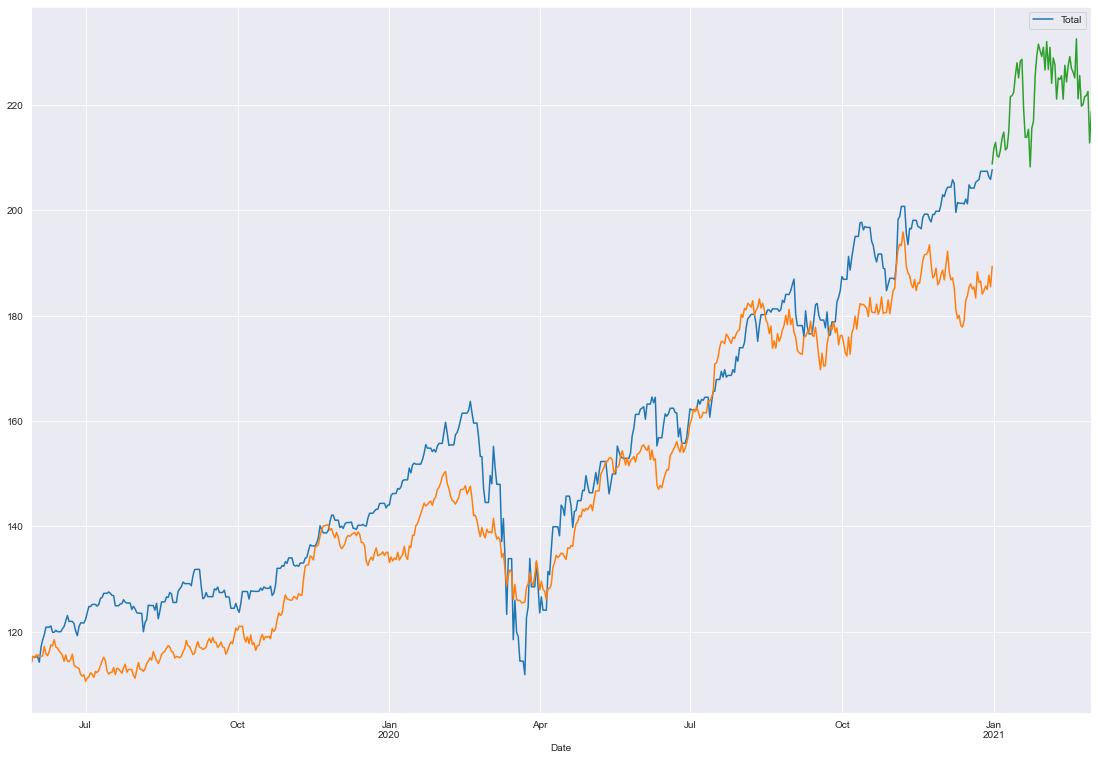

In [234]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:876] # First 80% 
test_df = tot_port_df.iloc[876:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # Orange
ax = prediction.plot(ax=ax) # Green

# Predict 100 days into the future
forecast = train_model.predict(start=end, end=end+60, dynamic=True)
ax = forecast.plot(ax=ax) # Green

In [235]:
tot_port_df

,Total
Date,
2017-01-03,66.985112
2017-01-04,67.814859
2017-01-05,68.241738
2017-01-06,68.252035
2017-01-07,68.252035
...,...
2020-12-27,207.415757
2020-12-28,207.434096
2020-12-29,206.362260


In [232]:
forecast

2020-12-31    208.798730
2021-01-01    211.727858
2021-01-02    212.918733
2021-01-03    210.365127
2021-01-04    210.124572
                 ...    
2021-12-27    372.790942
2021-12-28    378.952467
2021-12-29    377.000172
2021-12-30    382.457968
2021-12-31    362.831099
Freq: D, Length: 366, dtype: float64

In [226]:
import itertools

In [227]:
test_df

,Total
Date,
2019-05-29,113.955713
2019-05-30,115.233789
2019-05-31,115.165514
2019-06-01,115.165514
2019-06-02,115.165514
...,...
2020-12-27,207.415757
2020-12-28,207.434096
2020-12-29,206.362260


In [228]:
forecast = []
for num in prediction:
    forecast.append(num)

In [229]:
actual = []

for num in test_df['Total']:
    actual.append(num)

In [215]:
forecast

[1212.1660200216234,
 1229.5750757222668,
 1225.156388228291,
 1228.3979676405559,
 1232.2149183424629,
 1227.789969339169,
 1228.7665540954004,
 1226.7924303401023,
 1245.32829086039,
 1231.0148819960111,
 1226.9791990594683,
 1234.3692419406987,
 1247.9061192040929,
 1246.7729013036148,
 1261.5105214296232,
 1249.1813786258429,
 1248.7986979529046,
 1242.6557882868558,
 1235.7620452057502,
 1230.341318454749,
 1218.5539684223945,
 1229.6181520024243,
 1216.2620592434191,
 1214.4658580941516,
 1219.6503675382226,
 1228.9327871487537,
 1210.0231333119575,
 1207.1611451597005,
 1205.897116052327,
 1203.5266079260925,
 1189.578522284689,
 1187.7389450411406,
 1189.789389989977,
 1175.2035377586517,
 1180.5374723240257,
 1184.8919924374034,
 1196.6959914059169,
 1193.6781784365994,
 1189.0217858983276,
 1198.627931028791,
 1196.0270513057276,
 1204.9717272780026,
 1214.2837502440698,
 1220.1795580062583,
 1226.919941466707,
 1220.7135063252456,
 1202.7948945137555,
 1198.1518932946997,
 1

In [216]:
actual

[1211.6825046539307,
 1224.5267753601074,
 1222.9102630615234,
 1222.9102630615234,
 1222.9102630615234,
 1213.147813796997,
 1243.8463649749756,
 1257.6707916259766,
 1268.230842590332,
 1283.463005065918,
 1283.463005065918,
 1283.463005065918,
 1287.9409637451172,
 1276.3125267028809,
 1277.1463775634766,
 1281.9093780517578,
 1279.0302200317383,
 1279.0302200317383,
 1279.0302200317383,
 1283.4393348693848,
 1288.8577346801758,
 1299.8526039123535,
 1312.5008487701416,
 1301.909086227417,
 1301.909086227417,
 1301.909086227417,
 1296.632375717163,
 1282.533634185791,
 1273.7928066253662,
 1292.63454246521,
 1300.4706020355225,
 1300.4706020355225,
 1300.4706020355225,
 1307.9500999450684,
 1320.3080158233643,
 1332.4507656097412,
 1332.4507656097412,
 1336.6805000305176,
 1336.6805000305176,
 1336.6805000305176,
 1332.279067993164,
 1335.0185165405273,
 1345.030605316162,
 1346.3378143310547,
 1357.462142944336,
 1357.462142944336,
 1357.462142944336,
 1360.1423225402832,
 1359.144

In [217]:
# Define the dataset as python lists
# actual = [136, 120, 138, 155, 149]
# forecast = [134, 124, 132, 141, 149]

# Consider a list APE to store the
# APE value for each of the records in dataset
APE = []

# Iterate over the list values
for day in range(219):

	# Calculate percentage error
	per_err = (actual[day] - forecast[day]) / actual[day]

	# Take absolute value of
	# the percentage error (APE)
	per_err = abs(per_err)

	# Append it to the APE list
	APE.append(per_err)

# Calculate the MAPE
MAPE = sum(APE)/len(APE)

# Print the MAPE value and percentage
print(f'''
MAPE : { round(MAPE, 2) }
MAPE % : { round(MAPE*100, 2) } %
''')


MAPE : 0.06
MAPE % : 6.32 %



In [233]:
prediction

Date
2019-05-29    113.970196
2019-05-30    115.324611
2019-05-31    115.034366
2019-06-01    115.521216
2019-06-02    115.584181
                 ...    
2020-12-27    185.632894
2020-12-28    184.972289
2020-12-29    187.681529
2020-12-30    185.521203
2020-12-31    189.389356
Freq: D, Length: 583, dtype: float64